# Learning to make a market with competition

### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

from stable_baselines3 import PPO, SAC, DDPG
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

from labellines import labelLine, labelLines

In [2]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
resolution_value = 100

In [3]:
%load_ext autoreload
%autoreload 2

### Add mbt-gym to path

In [4]:
import sys
sys.path.append("../")

In [5]:
from mbt_gym.gym.index_names import TIME_INDEX, INVENTORY_INDEX, COMPETITION_STATE_INDEX

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion, BhsbMmCriterion
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.competition_inventory import BhsbInventoryModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction, CompetitionFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics, CompetitionLimitOrderModelDynamics

### Create market making environment

In [6]:
terminal_time = 1.0
bid_arrival_rate = 10.0
ask_arrival_rate = 10.0
n_steps = int(10 * terminal_time * np.maximum(bid_arrival_rate,ask_arrival_rate))
phi = 0.1
alpha = 0.03
beta = 0.05
sigma_z = 1.
sigma_s = 1.
S0 = 100
qmin = -10
qmax = 10
kappa = 2.
tick_size = 0.01

In [7]:
def get_bhsb_env(num_trajectories:int = 1):
    initial_inventory = (-4,5)
    fill_exponent = kappa
    initial_price = S0
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma_s, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([ask_arrival_rate, bid_arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = CompetitionFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories, tick_size= tick_size)
    competition_inventory_model = BhsbInventoryModel(min_value_inventory = -qmin,
                                            max_value_inventory = qmax,
                                            alpha = alpha,
                                            beta = beta,
                                            step_size = 1/n_steps,
                                            sigma = sigma_z,
                                            num_trajectories = num_trajectories)
    LOtrader = CompetitionLimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                competition_inventory_model = competition_inventory_model,
                                num_trajectories = num_trajectories,
                                max_depth = 10.,
                                min_depth = -3.)
    reward_function = BhsbMmCriterion(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha, a_tilde = 0.1, b_tilde=0.1,
                                     beta = beta, sigma = sigma_z)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=qmax,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [8]:
num_trajectories = 10000
env = ReduceStateSizeWrapper(env = get_bhsb_env(num_trajectories), list_of_state_indices = [INVENTORY_INDEX, TIME_INDEX, COMPETITION_STATE_INDEX, COMPETITION_STATE_INDEX+1])

In [9]:
Tenv = get_bhsb_env(10)

In [10]:
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [11]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"
best_model_path = "./SB_models/PPO-best-CJ"

### Define PPO policy

In [12]:
policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":3,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps)}
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [13]:
model.learn(total_timesteps = 500_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-CJ/PPO_38
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -8.81077 |
| time/              |          |
|    fps             | 730606   |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1000000  |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -7.4300914  |
| time/                   |             |
|    fps                  | 201561      |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 2000000     |
| train/                  |             |
|    approx_kl            | 0.004700654 |
|    clip_fraction        | 0.0242      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance 

In [14]:
model.save("PPO-learning-pooledcomp_500M")

## Comparing the learnt policy to the optimal policy

In [11]:
from mbt_gym.agents.SbAgent import SbAgent

In [12]:
model = PPO.load("PPO-learning-pooledcomp_500M")

seedno = 12345
rng = np.random.default_rng(seed=seedno)

#model = PPO.load("PPO-learning-pooledcomp")

In [13]:
ppo_agent = SbAgent(model, num_trajectories=10_000)

In [14]:
inventories = np.arange(-3,4,1)
bid_actions = []
ask_actions = []
for inventory in inventories:
    bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5, 0, 0]])).reshape(-1)
    bid_actions.append(bid_action)
    ask_actions.append(ask_action)    

In [15]:
inventories = np.arange(-5,6,1)
comp_inventories = np.arange(-9,10,1)

bid_actions = np.zeros((len(inventories),len(comp_inventories)))
ask_actions = np.zeros((len(inventories),len(comp_inventories)))
for iq, inventory in enumerate(inventories):
    for iqc, comp_inventory in enumerate(comp_inventories):
        bid_action, ask_action = ppo_agent.get_action(np.array([[inventory,0.5, comp_inventory, 0]])).reshape(-1)
        bid_actions[iq,iqc] = bid_action
        ask_actions[iq,iqc] = ask_action

In [16]:
q_vector = inventories
q_tilde_vector = comp_inventories
fs = 16
dpi = 300

from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from labellines import labelLines  # Assuming labelLines is imported from somewhere

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(q_vector), vmax=max(q_vector))
sm = ScalarMappable(norm=norm, cmap=cmap)

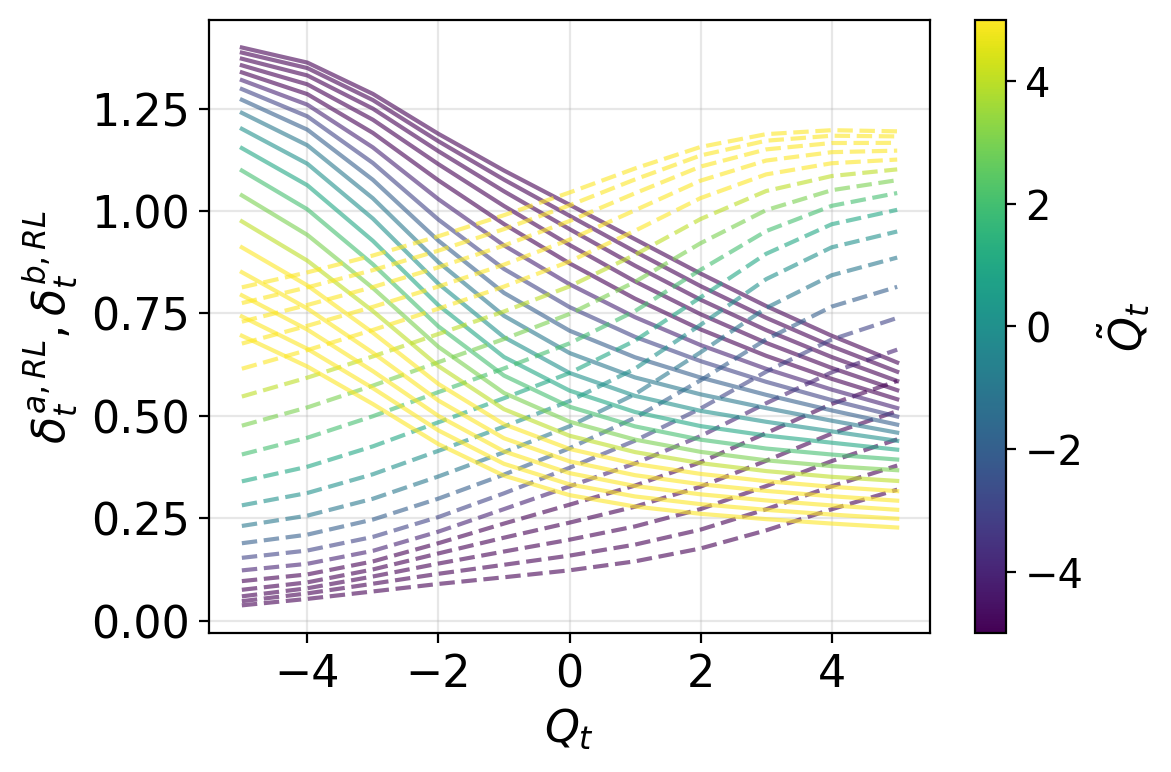

In [17]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

for i, q in enumerate(q_tilde_vector):
    color = cmap(norm(q_tilde_vector[i]))
    ax.plot(q_vector, ask_actions[:,i], '-', color=color, alpha=0.6)
    ax.plot(q_vector, bid_actions[:,i], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'${Q}_t$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\delta^{a,RL}_t, \delta^{b,RL}_t$', fontsize=fs)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label(r'$\tilde{Q}_t$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/RLapproxoptdepths.pdf', format="pdf", dpi=dpi)

plt.show()

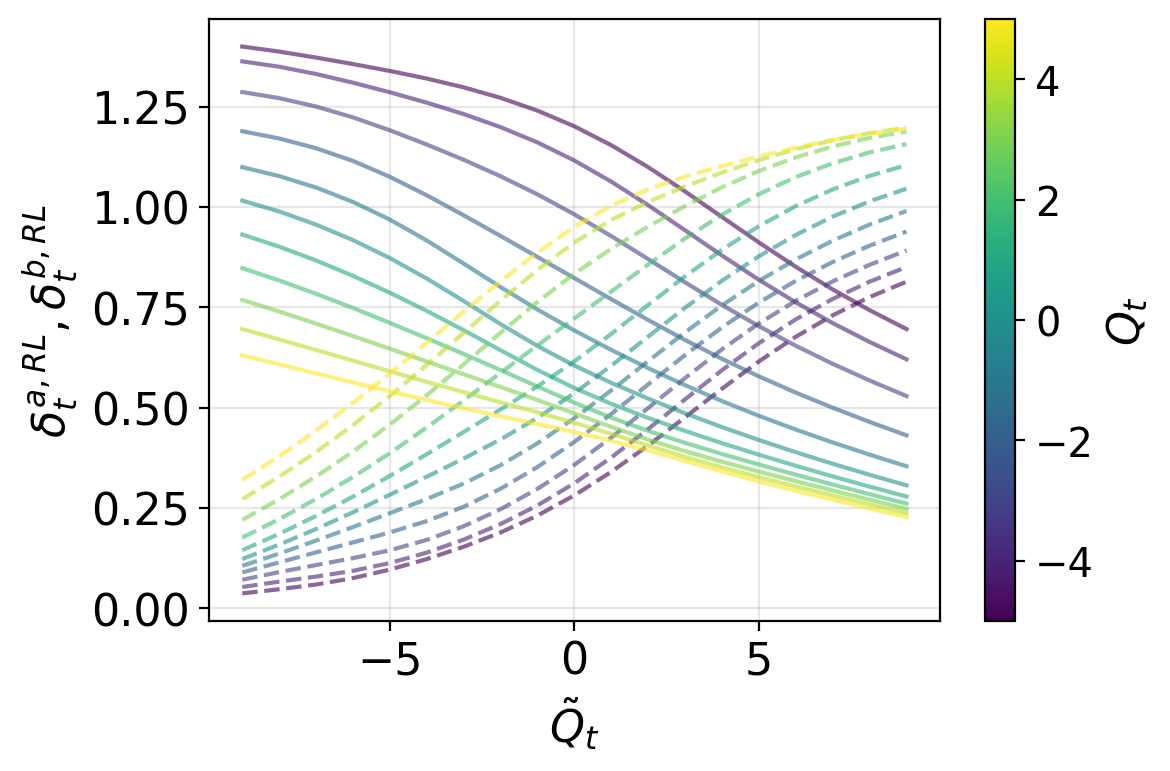

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

for i, q in enumerate(q_vector):
    color = cmap(norm(q_vector[i]))
    ax.plot(q_tilde_vector, ask_actions[i,:], '-', color=color, alpha=0.6)
    ax.plot(q_tilde_vector, bid_actions[i,:], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$\tilde{Q}_t$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\delta^{a,RL}_t, \delta^{b,RL}_t$', fontsize=fs)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label(r'${Q}_t$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/RLapproxoptdepths_v2.pdf', format="pdf", dpi=dpi)

plt.show()

In [45]:

from mbt_gym.agents.SbAgent import SbAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory


In [46]:
trained_agent = SbAgent(model, num_trajectories=1_000_000)

In [47]:
# step 1: evaluate
observations, actions, rewards = generate_trajectory(sb_env, trained_agent)
# results, fig, total_rewards = generate_results_table_and_hist(big_env, trained_agent)

In [48]:
total_rewards = rewards.sum(axis=-1).reshape(-1)
print('mean: ',np.mean(total_rewards))
print('median: ',np.median(total_rewards))
print('std: ',np.std(total_rewards))

mean:  3.1446143579432326
median:  3.2294634234693955
std:  2.7550160542332405


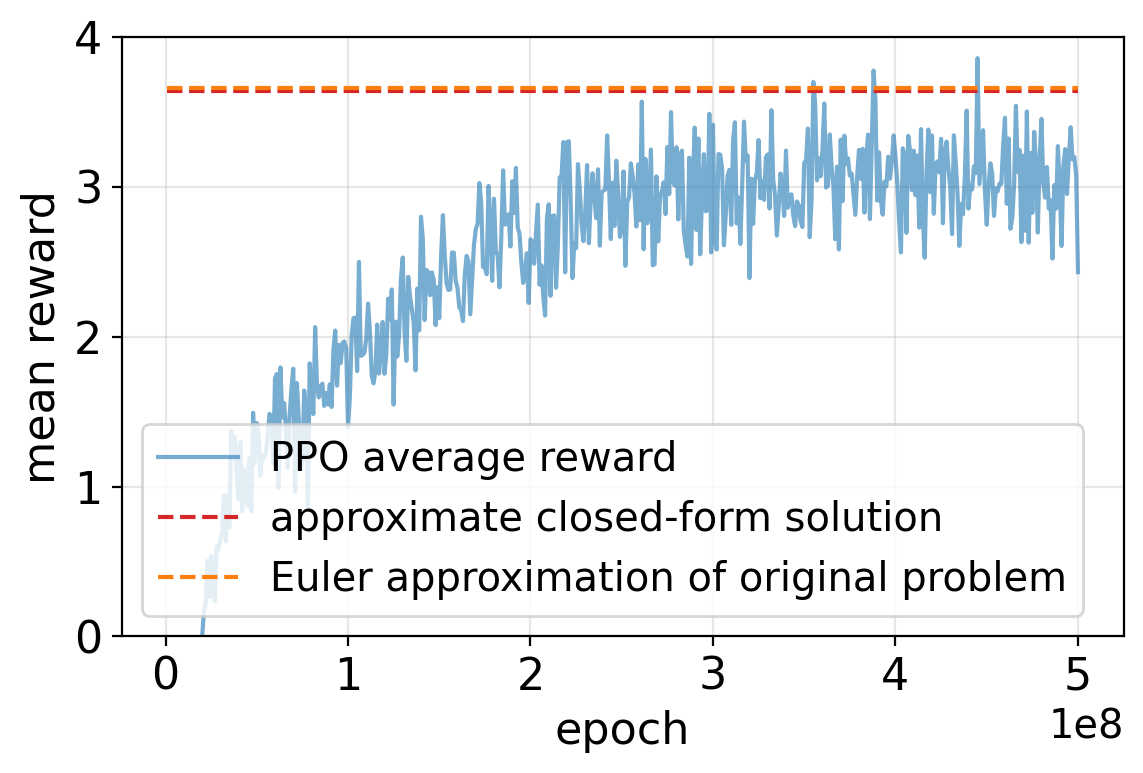

In [68]:
import pandas as pd
df = pd.read_csv('ep-reward.csv')
xmin = df['Step'].min()
xmax = df['Step'].max()
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

ax.plot(df['Step'], df.Value.values, '-', color='tab:blue', label='PPO average reward', alpha=0.6)

ax.hlines(y = 3.64, xmin=xmin, xmax=xmax, linestyles='--', color='tab:red', label= 'approximate closed-form solution')
ax.hlines(y = 3.66, xmin=xmin, xmax=xmax, linestyles='--', color='tab:orange', label= 'Euler approximation of original problem')

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'epoch', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'mean reward', fontsize=fs)
plt.legend()
plt.ylim([0,4])
plt.tight_layout()
plt.savefig('figures/RL-PPO-versus-approximate-closed-form.pdf', format="pdf", dpi=dpi)

plt.show()

# ********

# ********

# OTHER POLICIES

# ********

# ********

### Define SAC policy

policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])
SAC_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1,
              "tensorboard_log":tensorboard_logdir}
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)
model = SAC(**SAC_params, device="cpu")

model.learn(total_timesteps = 30_000_000)  # Increase number of training timesteps according to computing resources

model.save("SAC-learning-pooledcomp")

## Comparing the learnt policy to the optimal policy

from mbt_gym.agents.SbAgent import SbAgent

model = SAC.load("SAC-learning-pooledcomp")

rl_agent = SbAgent(model, num_trajectories=10_000)